# Running Simulations On One Patient

To demonstrate how to get variability in the source and SEEG space, we will perform experiments on one patient here by varying the bifurcation parameters Iext and eps1. 



In [53]:
import sys
import numpy as np
import os

sys.path.append('../../../')
from tvb.simulator.lab import *
import tvbsim

# to run simulation and post processing and data loading
from tvbsim.postprocess.postprocess import PostProcessor
from tvbsim.postprocess.detectonsetoffset import DetectShift
from tvbsim.maintvbexp import MainTVBSim
from tvbsim.execute.cluster.hpc_tvbsimmodel import SimVsRealModel
from tvbsim.io.patient.subject import Subject
from tvbsim.io.loadsimdataset import LoadSimDataset
from tvbsim.base.constants.config import Config

sys.path.append('../../../bintng/util/')
from run_freq import FreqAnalysis
output_folder = os.path.join(os.path.expanduser("~"), 'Documents', 'figures',
                             'tvbsims')

# to run plotting at the end
from tvbsim.visualize.plotter_sim import PlotterSim
from tvbsim.base.dataobjects.timeseries import TimeseriesDimensions, Timeseries 
from collections import OrderedDict

from tvbsim.execute.cluster.hpc_tvbsimmodel import TVBSimModel

# import basic plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# configuration and plotting
config = Config(output_base=output_folder) 
config.figures.MATPLOTLIB_BACKEND="qt5" #"Qt4Agg" #"inline"
config.figures.SHOW_FLAG=True

import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

# Import magic commands for jupyter notebook 
# - autoreloading a module
# - profiling functions for memory usage and scripts
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%load_ext memory_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [106]:
def run_freq_analysis(rawdata, metadata, mode, outputfilename, outputmetafilename):
    ''' RUN FREQ DECOMPOSITION '''
    winsize = 5000
    stepsize = 2500

    if mode == 'fft':
        metadata['winsize'] = winsize
        metadata['stepsize'] = stepsize
        metadata['fftfilename'] = outputfilename
        print(metadata.keys())
        run_freq(metadata, rawdata, mode, outputfilename, outputmetafilename)

    if mode=='morlet':    
        metadata['winsize'] = winsize
        metadata['stepsize'] = stepsize
        metadata['morletfilename'] = outputfilename
        run_freq(metadata, rawdata, mode, outputfilename, outputmetafilename)

def load_raw_data(patdatadir, datafile, metadatadir, patient, reference):
    loader = LoadSimDataset(root_dir=patdatadir, 
                                datafile=datafile, 
                                rawdatadir=metadatadir, 
                                patient=patient,
                                reference=reference, 
                                preload=True)
    # get filtered/referenced rawdata
    rawdata = loader.rawdata 
    metadata = loader.getmetadata()

    return rawdata, metadata

def run_freq(metadata, rawdata, mode, outputfilename, outputmetafilename):
    print(metadata.keys())
    samplerate = metadata['samplerate']
    samplerate = 2000
    if mode == 'fft':
        # FFT Parameters
        mtbandwidth = 4
        mtfreqs = []
        fftargs = {"winsize": metadata['winsize'], 
                    "stepsize": metadata['stepsize'],
                    "samplerate": samplerate, 
                    "mtfreqs":mtfreqs, 
                    "mtbandwidth":mtbandwidth}
        # run fft
        power, freqs, phase, timepoints = FreqAnalysis.run_fft(rawdata, fftargs)

        # add to metadata
        metadata['mtbandwidth'] = mtbandwidth
        metadata['freqs'] = freqs
    elif mode == 'morlet':
        # Wavelet Parameters
        waveletfreqs = 2**(np.arange(1.,9.,1./5))
        waveletwidth = 6
        waveletargs = {"winsize": metadata['winsize'], 
                        "stepsize": metadata['stepsize'],
                        "samplerate": samplerate, 
                        "waveletfreqs":waveletfreqs, 
                        "waveletwidth":waveletwidth}
        # run morlet
        power, phase, timepoints = FreqAnalysis.run_morlet(rawdata, waveletargs)

        metadata['freqs'] = waveletfreqs
        metadata['waveletwidth'] = waveletwidth

    # add the consistent parameters
    metadata['timepoints'] = timepoints
    
    # save the data
    print("saving freq data at ", outputfilename)
    FreqAnalysis.save_data(outputfilename, outputmetafilename, power, phase, metadata)
    print("successfully saved!")

In [33]:
patient = 'id001_bt'
period = 1
sim_length = 30000
root_dir = '/Users/adam2392/Downloads/tngpipeline/'

# initialize runner and run
hpcrunner = SimVsRealModel(patient, period, sim_length)
hpcrunner.loadalldata(root_dir, ezinside=True)
hpcrunner.initialize_tvb_model()

2018-06-19 11:12:40,279 - DEBUG - Subject - 
Already renamed seeg.xyz possibly!

2018-06-19 11:12:40,279 - DEBUG - Subject - 
Already renamed seeg.xyz possibly!

2018-06-19 11:12:40,279 - DEBUG - Subject - 
Already renamed seeg.xyz possibly!

2018-06-19 11:12:40,279 - DEBUG - Subject - 
Already renamed seeg.xyz possibly!

2018-06-19 11:12:40,279 - DEBUG - Subject - 
Already renamed seeg.xyz possibly!

2018-06-19 11:12:40,279 - DEBUG - Subject - 
Already renamed seeg.xyz possibly!

2018-06-19 11:12:40,279 - DEBUG - Subject - 
Already renamed seeg.xyz possibly!

2018-06-19 11:12:40,279 - DEBUG - Subject - 
Already renamed seeg.xyz possibly!

2018-06-19 11:12:40,361 - DEBUG - Subject - 
Already renamed gaininv.mat possibly!

2018-06-19 11:12:40,361 - DEBUG - Subject - 
Already renamed gaininv.mat possibly!

2018-06-19 11:12:40,361 - DEBUG - Subject - 
Already renamed gaininv.mat possibly!

2018-06-19 11:12:40,361 - DEBUG - Subject - 
Already renamed gaininv.mat possibly!

2018-06-19 11:12

In [34]:
print(hpcrunner.maintvbexp.getepileptorparams())

{'tau': array([10]), 'tt': array([0.07]), 'ks': array([-10]), 'r': array([0.00037]), 'iext': array([3.1]), 'x0': array([-1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 ,
       -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 ,
       -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 ,
       -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 ,
       -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 ,
       -1.6 , -1.65, -1.65, -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 ,
       -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 ,
       -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 ,
       -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 , -1.6 ,
       -1.6 , -1.6 , -1.6 ]), 'eps1': array([0.])}


In [35]:
## OUTPUTFILE NAME ##
i = 0
outputdatadir = '~/Downloads/simexp/'
if not os.path.exists(outputdatadir):
    os.makedirs(outputdatadir)
outputfilename = os.path.join(outputdatadir,
            '{}_{}.npz'.format(patient, i))
metafilename = os.path.join(outputdatadir,
            '{}_{}.json'.format(patient, i))

epits, seegts, zts, state_vars = hpcrunner.run(outputfilename, metafilename)

[   0. 4239. 8069.]
[  598. 12722.    nan]
returning cuz prevoffset is nan!
The detected onset/offsets are: [(0.0, 598.0)]


In [37]:
print(hpcrunner.modelezinds)
print(epits.shape)

[46, 47]
(84, 15000)


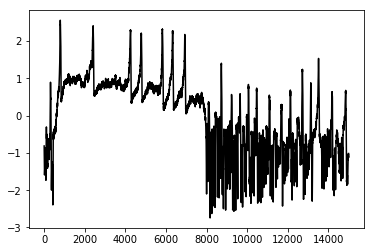

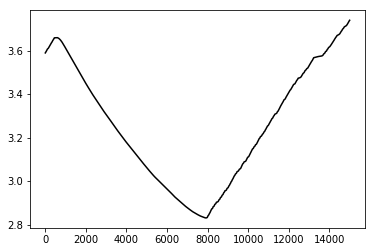

In [38]:
plt.figure()
plt.plot(epits[46,:], 'k')

plt.figure()
plt.plot(zts[46,:], 'k')

# Run Morlet Frequency Analysis and Visualize Output

- Check source 
- Check SEEG level


In [48]:
# load in the data to run frequency analysis
reference = 'monopolar'
patdatadir = outputdatadir
metadatadir = root_dir
datafile = outputfilename
rawdata, metadata = load_raw_data(patdatadir, datafile, metadatadir, patient, reference)

2018-06-19 11:24:56,483 - DEBUG - LoadSimDataset - Reading in metadata!
2018-06-19 11:24:56,483 - DEBUG - LoadSimDataset - Reading in metadata!
2018-06-19 11:24:56,483 - DEBUG - LoadSimDataset - Reading in metadata!
2018-06-19 11:24:56,488 - DEBUG - LoadSimDataset - 
Already renamed seeg.xyz possibly!

2018-06-19 11:24:56,488 - DEBUG - LoadSimDataset - 
Already renamed seeg.xyz possibly!

2018-06-19 11:24:56,488 - DEBUG - LoadSimDataset - 
Already renamed seeg.xyz possibly!

2018-06-19 11:24:56,509 - DEBUG - LoadSimDataset - 
Loaded in seeg xyz coords!

2018-06-19 11:24:56,509 - DEBUG - LoadSimDataset - 
Loaded in seeg xyz coords!

2018-06-19 11:24:56,509 - DEBUG - LoadSimDataset - 
Loaded in seeg xyz coords!

2018-06-19 11:25:01,530 - DEBUG - LoadSimDataset - 
Mapped contacts to regions!

2018-06-19 11:25:01,530 - DEBUG - LoadSimDataset - 
Mapped contacts to regions!

2018-06-19 11:25:01,530 - DEBUG - LoadSimDataset - 
Mapped contacts to regions!

2018-06-19 11:25:01,540 - INFO - Load

In [107]:
mode = 'fft'
# create checker for num wins
freqoutputdir = os.path.join(outputdatadir, 'freq', mode, patient)
if not os.path.exists(freqoutputdir):
    os.makedirs(freqoutputdir)
# where to save final computation
outputfilename = os.path.join(freqoutputdir, 
        '{}_{}_{}model.npz'.format(patient, mode, i))
outputmetafilename = os.path.join(freqoutputdir,
    '{}_{}_{}meta.json'.format(patient, mode, i))
run_freq_analysis(rawdata, metadata, mode, outputfilename, outputmetafilename)


[u'ez_region', u'reference', u'onsetsec', u'timepoints', u'sim_ez_reg', u'region_labels', u'samplerate', u'chanlabels', u'sim_x0_pz', u'sim_x0_norm', u'waveletwidth', u'sim_x0_ez', u'contact_regs', u'morletfilename', u'chanxyz', u'patient', u'offsetsec', u'offsetind', u'stepsize', u'onsetind', u'waveletfreqs', u'linefreq', u'fftfilename', u'sim_pz_reg', u'freqs', u'winsize', u'allchans', u'record_date', u'lowpass_freq', u'mtbandwidth', u'rawfilename', u'highpass_freq']
[u'ez_region', u'reference', u'onsetsec', u'timepoints', u'sim_ez_reg', u'region_labels', u'samplerate', u'chanlabels', u'sim_x0_pz', u'sim_x0_norm', u'waveletwidth', u'sim_x0_ez', u'contact_regs', u'morletfilename', u'chanxyz', u'patient', u'offsetsec', u'offsetind', u'stepsize', u'onsetind', u'waveletfreqs', u'linefreq', u'fftfilename', u'sim_pz_reg', u'freqs', u'winsize', u'allchans', u'record_date', u'lowpass_freq', u'mtbandwidth', u'rawfilename', u'highpass_freq']
2018-06-19 13:14:25,223 - INFO - MultiTaperFFT - Def

In [100]:
mode = 'fft'
# create checker for num wins
freqoutputdir = os.path.join(outputdatadir, 'freq', mode, patient)
if not os.path.exists(freqoutputdir):
    os.makedirs(freqoutputdir)
# where to save final computation
outputfilename = os.path.join(freqoutputdir, 
        '{}_{}_{}model_epi.npz'.format(patient, mode, i))
outputmetafilename = os.path.join(freqoutputdir,
    '{}_{}_{}meta_epi.json'.format(patient, mode, i))
run_freq_analysis(epits, metadata, mode, outputfilename, outputmetafilename)


[u'ez_region', u'reference', u'onsetsec', u'freqs', u'sim_ez_reg', u'region_labels', u'samplerate', u'chanlabels', u'sim_x0_pz', u'sim_x0_norm', u'waveletwidth', u'sim_x0_ez', u'contact_regs', u'morletfilename', u'chanxyz', u'patient', u'offsetsec', u'offsetind', u'stepsize', u'onsetind', u'waveletfreqs', u'linefreq', u'fftfilename', u'sim_pz_reg', u'timepoints', u'winsize', u'allchans', u'record_date', u'lowpass_freq', u'mtbandwidth', u'rawfilename', u'highpass_freq']
[u'ez_region', u'reference', u'onsetsec', u'freqs', u'sim_ez_reg', u'region_labels', u'samplerate', u'chanlabels', u'sim_x0_pz', u'sim_x0_norm', u'waveletwidth', u'sim_x0_ez', u'contact_regs', u'morletfilename', u'chanxyz', u'patient', u'offsetsec', u'offsetind', u'stepsize', u'onsetind', u'waveletfreqs', u'linefreq', u'fftfilename', u'sim_pz_reg', u'timepoints', u'winsize', u'allchans', u'record_date', u'lowpass_freq', u'mtbandwidth', u'rawfilename', u'highpass_freq']
2018-06-19 12:48:00,259 - INFO - MultiTaperFFT - Def

# Visualize FFT Analysis Results

In [108]:
import io
import json

with io.open(outputmetafilename, mode='r', encoding="utf-8") as f:
    json_str = json.load(f)
metadata = json.loads(json_str)
npystruct = np.load(outputfilename)
power = npystruct['power']

print(power.shape)
print(metadata.keys())

chanlabels = metadata['chanlabels']
freqs = metadata['freqs']
onsetind = metadata['onsetind']
offsetind = metadata['offsetind']
contact_regs = metadata['contact_regs']
print(len(chanlabels))
print(min(power.ravel()))
print(max(power.ravel()))
print(onsetind)
print(offsetind)
print(len(contact_regs))

contact_regs = np.array(contact_regs).astype(int)
sensorezinds = np.where(contact_regs == 46)[0]

(137, 5001, 2)
[u'ez_region', u'reference', u'onsetsec', u'freqs', u'sim_ez_reg', u'region_labels', u'samplerate', u'chanlabels', u'sim_x0_pz', u'sim_x0_norm', u'waveletwidth', u'sim_x0_ez', u'contact_regs', u'morletfilename', u'chanxyz', u'patient', u'offsetsec', u'offsetind', u'stepsize', u'onsetind', u'waveletfreqs', u'linefreq', u'fftfilename', u'sim_pz_reg', u'timepoints', u'winsize', u'allchans', u'record_date', u'lowpass_freq', u'mtbandwidth', u'rawfilename', u'highpass_freq']
137
-8.669803552856617
0.4267410020163163
[0.0, 4239.0]
[598.0]
137


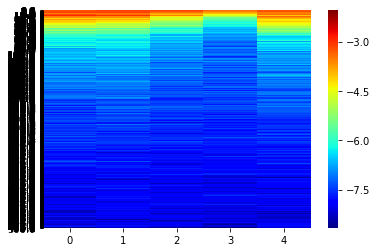

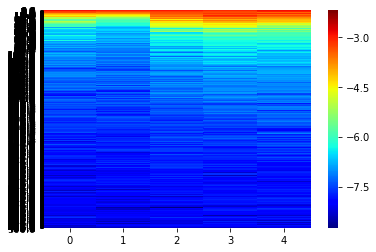

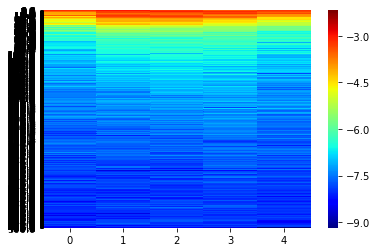

In [102]:
toplot = [45,46,47]
for i in toplot:
    plt.figure()
    sns.heatmap(power[i,...].squeeze(), cmap='jet', yticklabels=freqs)

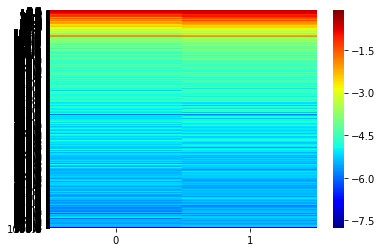

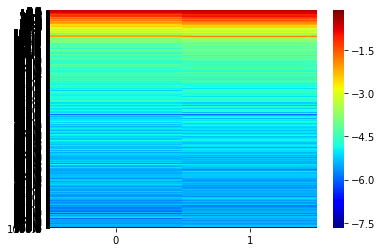

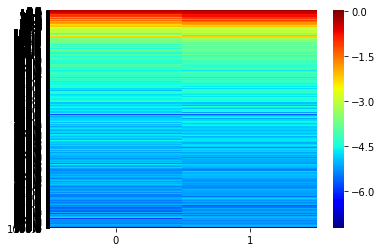

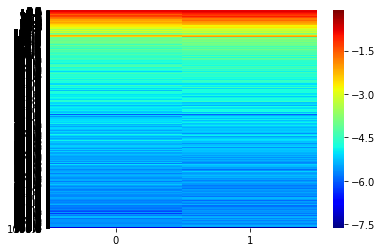

In [110]:
toplot = [82, 83, 84, 85]
for i in toplot:
    plt.figure()
    sns.heatmap(power[i,...].squeeze(), cmap='jet', yticklabels=freqs)

# Visualize Morlet Analysis Results

In [71]:
import io
import json

with io.open(outputmetafilename, mode='r', encoding="utf-8") as f:
    json_str = json.load(f)
metadata = json.loads(json_str)
npystruct = np.load(outputfilename)
power = npystruct['power']

print(power.shape)
print(metadata.keys())

chanlabels = metadata['chanlabels']
freqs = metadata['freqs']
onsetind = metadata['onsetind']
offsetind = metadata['offsetind']
contact_regs = metadata['contact_regs']
print(len(chanlabels))
print(min(power.ravel()))
print(max(power.ravel()))
print(onsetind)
print(offsetind)
print(len(contact_regs))

contact_regs = np.array(contact_regs).astype(int)
sensorezinds = np.where(contact_regs == 46)[0]

(137, 40, 15000)
[u'ez_region', u'reference', u'onsetsec', u'sim_ez_reg', u'region_labels', u'samplerate', u'chanlabels', u'sim_x0_pz', u'sim_x0_norm', u'waveletwidth', u'sim_x0_ez', u'contact_regs', u'morletfilename', u'chanxyz', u'patient', u'offsetsec', u'offsetind', u'stepsize', u'onsetind', u'waveletfreqs', u'linefreq', u'sim_pz_reg', u'timepoints', u'winsize', u'allchans', u'record_date', u'lowpass_freq', u'rawfilename', u'highpass_freq']


In [85]:
import io
import json

with io.open(outputmetafilename, mode='r', encoding="utf-8") as f:
    json_str = json.load(f)
metadata = json.loads(json_str)
npystruct = np.load(outputfilename)
power = npystruct['power']

print(power.shape)
print(metadata.keys())

chanlabels = metadata['chanlabels']
freqs = metadata['freqs']
onsetind = metadata['onsetind']
offsetind = metadata['offsetind']
contact_regs = metadata['contact_regs']
print(len(chanlabels))
print(min(power.ravel()))
print(max(power.ravel()))
print(onsetind)
print(offsetind)
print(len(contact_regs))

(84, 40, 15000)
[u'ez_region', u'reference', u'onsetsec', u'sim_ez_reg', u'region_labels', u'samplerate', u'chanlabels', u'sim_x0_pz', u'sim_x0_norm', u'waveletwidth', u'sim_x0_ez', u'contact_regs', u'morletfilename', u'chanxyz', u'patient', u'offsetsec', u'offsetind', u'stepsize', u'onsetind', u'waveletfreqs', u'linefreq', u'sim_pz_reg', u'timepoints', u'winsize', u'allchans', u'record_date', u'lowpass_freq', u'rawfilename', u'highpass_freq']
137
-8.117932583153953
5.065279415192863
[0.0, 4239.0]
[598.0]
137


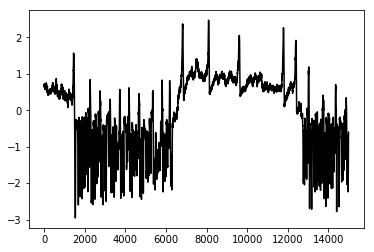

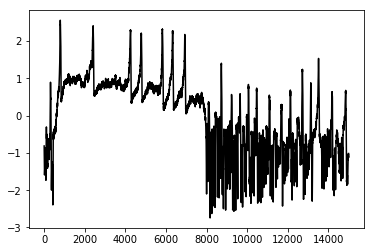

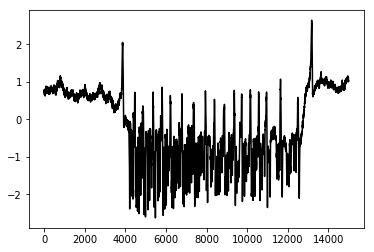

In [87]:
toplot = [45,46,47]
for i in toplot:
    plt.figure()
    plt.plot(epits[i,:], 'k')


In [105]:
# toplot = [45,46,47]
# for i in toplot:
#     plt.figure()
#     sns.heatmap(power[i,...].squeeze(), cmap='jet', yticklabels=freqs)

In [104]:
# toplot = [82, 83, 84, 85]
# for i in toplot:
#     plt.figure()
#     sns.heatmap(power[i,...].squeeze(), cmap='jet', yticklabels=freqs)

In [103]:
# for i in range(10):
#     plt.figure()
#     sns.heatmap(power[-i,...].squeeze(), cmap='jet', yticklabels=freqs)